In [3]:
import numpy as np
import aa as aa
import matplotlib.pyplot as plt
import scipy.linalg as la
plt.style.use('classic')

/Users/bodonoghue/miniconda2/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if __name__ == '__main__':


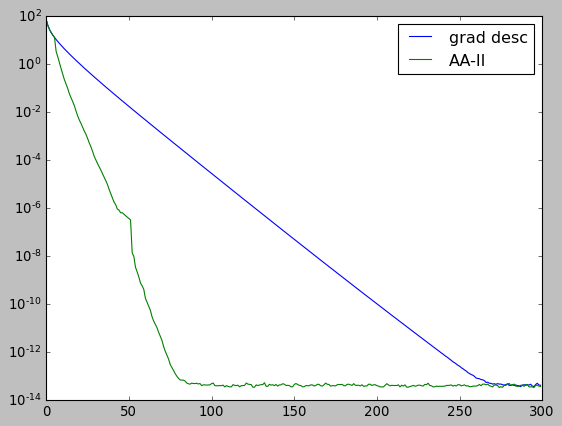

In [4]:
# Solving least squarse min_x ||Ax - b||^2

np.random.seed(123)

n = 100
m = 300
A = np.random.randn(m,n)
b = np.random.randn(m,1)
x_star = np.linalg.lstsq(A, b)[0]
f_star = 0.5 * (np.linalg.norm(A.dot(x_star) - b) ** 2)
N = 300
t = 0.002

gs_vanilla = []
gs_aa_1 = []
gs_aa_2 = []

x = np.zeros((n,1))
for i in range(N):
    x -= t * A.T.dot(A.dot(x) - b)
    gs_vanilla.append(np.linalg.norm( A.T.dot(A.dot(x) - b)))
    

aa_mem = 5


aa_wrk = aa.AndersonAccelerator(n, aa_mem)
x = np.zeros((n,1))
for i in range(N):
    if i > 0: aa_wrk.apply(x, x_prev)
    x_prev = np.copy(x)
    x -= t * A.T.dot(A.dot(x) - b)
    aa_wrk.safeguard(x, x_prev)
    gs_aa_2.append(np.linalg.norm( A.T.dot(A.dot(x) - b)))

    
plt.semilogy(gs_vanilla, label='grad desc')
plt.semilogy(gs_aa_2, label='AA-II')

plt.legend()
plt.show()


====================== Type - II ======================
 reset.
AA rejection, iter: 9, norm_diff 3.0883e-12, prev_norm_diff 3.0711e-12
AA reset.
AA rejection, iter: 9, norm_diff 3.0814e-12, prev_norm_diff 3.0777e-12
AA reset.
AA rejection, iter: 6, norm_diff 3.0903e-12, prev_norm_diff 3.0638e-12
AA reset.
AA rejection, iter: 9, norm_diff 3.0722e-12, prev_norm_diff 3.0668e-12
AA reset.
AA rejection, iter: 6, norm_diff 3.0656e-12, prev_norm_diff 3.0616e-12
AA reset.
AA rejection, iter: 8, norm_diff 3.0804e-12, prev_norm_diff 3.0713e-12
AA reset.
AA rejection, iter: 8, norm_diff 3.0699e-12, prev_norm_diff 3.0420e-12
AA reset.
AA rejection, iter: 6, norm_diff 3.0396e-12, prev_norm_diff 3.0357e-12
AA reset.
AA rejection, iter: 6, norm_diff 3.0384e-12, prev_norm_diff 3.0356e-12
AA reset.
AA rejection, iter: 7, norm_diff 3.0462e-12, prev_norm_diff 3.0380e-12
AA reset.
AA rejection, iter: 9, norm_diff 3.0302e-12, prev_norm_diff 3.0130e-12
AA reset.
AA rejection, iter: 7, norm_diff 3.0295e-12, 

AA rejection, iter: 101, norm_diff 1.5120e-02, prev_norm_diff 1.5017e-02
AA reset.
AA rejection, iter: 104, norm_diff 8.4900e-03, prev_norm_diff 8.2746e-03
AA reset.
AA rejection, iter: 101, norm_diff 4.8731e-03, prev_norm_diff 4.7402e-03
AA reset.
AA rejection, iter: 108, norm_diff 2.9983e-03, prev_norm_diff 2.9910e-03
AA reset.
AA rejection, iter: 102, norm_diff 1.9658e-03, prev_norm_diff 1.9353e-03
AA reset.
AA rejection, iter: 101, norm_diff 8.3734e-02, prev_norm_diff 1.6771e-03
AA reset.
AA rejection, iter: 101, norm_diff 9.6023e-03, prev_norm_diff 1.4587e-03
AA reset.
AA rejection, iter: 101, norm_diff 3.3570e-03, prev_norm_diff 1.1119e-03
AA reset.
AA rejection, iter: 101, norm_diff 1.3525e-03, prev_norm_diff 8.7405e-04
AA reset.
AA rejection, iter: 103, norm_diff 6.7333e-04, prev_norm_diff 6.7200e-04
AA reset.
AA rejection, iter: 101, norm_diff 1.1542e-03, prev_norm_diff 5.2263e-04
AA reset.
AA rejection, iter: 102, norm_diff 3.9738e-04, prev_norm_diff 3.9707e-04
AA reset.
AA r

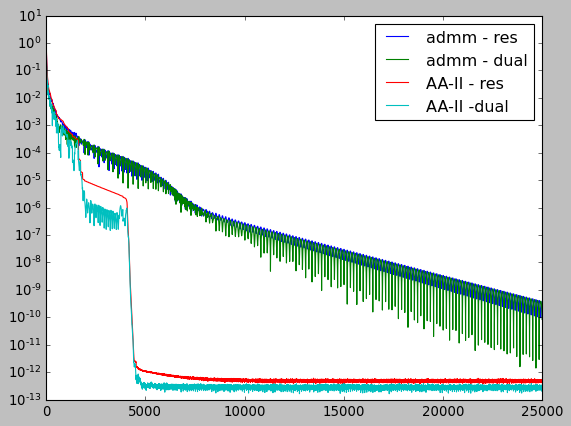

In [12]:
# l1 regularized least squares

np.random.seed(123)

n = 300
m = 100
mu = 0.1
rho = 0.1
N = 25_000

A = np.random.randn(m,n)
b = np.random.randn(m,1)

L = la.cho_factor(A.T.dot(A) + rho * np.identity(n))

def soft_thresh(y, t):
    return np.sign(y) * np.maximum(abs(y) - t, 0)

 
z0 = np.linalg.solve(A.T.dot(A), A.T.dot(b))

z = z0
lam = np.zeros((n,1))
res_vanilla = []
ds_vanilla = []
for i in range(N):
    z_old = z
    x = la.cho_solve(L, rho * (z + lam) + A.T.dot(b))
    z = soft_thresh(x - lam, mu / rho)
    lam = lam - x + z
    res_vanilla.append(np.linalg.norm(x-z))
    ds_vanilla.append(np.linalg.norm(z - z_old))

    
aa_mem = 100

print("====================== Type - II ======================")
z = z0
lam = np.zeros((n,1))
u = np.vstack((z,lam))
aa_wrk = aa.AndersonAccelerator(2 * n, aa_mem, safeguard_factor=1, verbosity=1)
res_aa_2 = []
ds_aa_2 = []
for i in range(N):
    if i > 0: aa_wrk.apply(u, u_old)
    u_old = np.copy(u)
    x = la.cho_solve(L, rho * (z + lam) + A.T.dot(b))
    z = soft_thresh(x - lam, mu / rho)
    lam = lam - x + z
    u = np.vstack((z, lam))
    aa_wrk.safeguard(u, u_old)
    z = u[:n]
    z_old = u_old[:n]
    lam = u[n:]
    
    res_aa_2.append(np.linalg.norm(la.cho_solve(L, rho * (z + lam) + A.T.dot(b)) - z))
    ds_aa_2.append(np.linalg.norm(z - z_old))


plt.semilogy(res_vanilla, label='admm - res')
plt.semilogy(ds_vanilla, label='admm - dual')
plt.semilogy(res_aa_2, label='AA-II - res')
plt.semilogy(ds_aa_2, label='AA-II -dual')
#plt.semilogy(res_aa_1_p, label='AA-I-P - res')
#plt.semilogy(ds_aa_1_p, label='AA-I-P - dual')

plt.legend()
plt.show()